In [1]:
import cvxpy as cp

#Additional packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from array import *
from statistics import mean
from itertools import chain
from scipy import signal, spatial
import math
from tqdm import tqdm

#Profiling
import time
#from guppy import hpy
pd.options.mode.chained_assignment = None  # default='warn'

# Modeling the studied distribution network

In [2]:
#Optimization Temporal Values
t_end = 60     #Total duration of the study(in minutes)
del_T = 15     #Imbalance Settlement Period (in minutes)
del_t = 1      #Temporal resolution of the study (in minutes)
interval = del_t

#Network Base and Nominal values
#Base Values
v_base_sec = 0.416e3                                #Base voltage of secondary side of the distribution network
s_base = 0.315e6                                    #Base power of the distribution network
v_base_prim = 11e3                                  #Base voltage of primary side of the distribution network
z_base_sec = (v_base_sec*v_base_sec)/s_base         #Base impedance of the secondary side of the distribution network
z_base_prim = (v_base_prim*v_base_prim)/s_base      #Base voltage of primary side of the distribution network
#Nominal values
nom_voltage = 0.416e3      #Nominal Voltage
voltage_tolerance = 5      #Voltage tolerance (in %)
s_max=s_base      #Max apparent power  of the distribution network



#PVs values
Area = 10                 #Area of the PV panel (in m2)
Eff = 0.17                #Efficiency of the panel
Temp_cnst = -0.0032       #Temperature constant of the panel
T_stc=25                  #"Standard Test Conditions" temperature of the PVs
PR = 0.8                  #"Performance Ratio" of the panel


#EVs Values
eff_chrg = 0.95        #Charging Efficiency of the EVs(in %)
eff_dischrg = 0.96     #Discharging Efficiency of the EVs(in %)
E_bat = 30e3           #Rated Energy Capacity of the EVs (in Wh)
p_max = 7              #Rated Active Power of the EVs (in kW)
q_max = 3              #Rated Reactive Power of the EVs (in kVAR) [NOT USED YET]
e_bat = E_bat
soc_min = 0.3                 #Minimum SOC of the EVs
soc_max = 0.8                 #Maximum SOC of the EVs
soc_min_depart = 0.7          #Minimum SOC of the EVs at the time of its departure
n_cycles=14000                                 #No. of total cycles of the EVs battery
dod = 40/100                                   #Depth of discharge of the EVs battery
e_tp = eff_dischrg*n_cycles*E_bat*dod          #"Throughput" of the EVs battery
cost_bat=4500          #Total Cost of the battry



#Forecasting Error Values
err_pv=0.15          #Error in the PV forecast
err_load=0           #Error in the load forecast
err_ev=0             #Error in the EV forecast

In [3]:
# Lines and Bus data to construct impedance matrix
lines_codes_df = pd.read_csv(r'../data/network/European_LV_CSV_simplified/LineCodes.csv', index_col=False, skiprows=1)
lines_df = pd.read_csv(r'../data/network/European_LV_CSV_simplified/Lines_reduced.csv', index_col=False, skiprows=1)
bus_df = pd.read_csv(r'../data/network/European_LV_CSV_simplified/Buscoords_reduced.csv', index_col=False, skiprows=1)

#Load data for optimization
load_data_df = pd.read_csv(r'../data/network/European_LV_CSV_simplified/Loads_reduced.csv', index_col=False, skiprows=2)

In [4]:
lines_df['susceptance'] = 0
lines_df['conductance'] = 0
bus_tot = bus_df['Busname'].iloc[-1]

In [5]:
lines_df

Name  Bus1  Bus2 Phases    Length Units    LineCode  length_km  \
0      LINE1     1     2    ABC  16.64684     m       4c_70   0.016647   
1    LINE103    18    24    ABC  14.67517     m      4c_.35   0.014675   
2    LINE104    18    20    ABC   8.79792     m       4c_70   0.008798   
3    LINE116    20    21    ABC   1.10560     m      4c_.35   0.001106   
4    LINE117    20    39    ABC  28.18684     m       4c_.1   0.028187   
..       ...   ...   ...    ...       ...   ...         ...        ...   
199  Line(5)   191   199    ABC   7.50839     m    2c_.0225   0.007508   
200  Line(6)   198   202    ABC  10.33630     m  35_SAC_XSC   0.010336   
201  Line(7)   198   205    ABC   8.09168     m       2c_16   0.008092   
202  Line(8)   178   191    ABC  10.12454     m    2c_.0225   0.010125   
203  Line(9)   164   198    ABC  10.77222     m       2c_16   0.010772   

     susceptance  conductance  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
199            0            0  
200            0            0  
201            0            0  
202            0            0  
203            0            0  

[204 rows x 10 columns]

In [6]:
#Grid connection isn't specified in the given network files so the connection values are added here.
#Transformers Paramters
X1_tfo_pu = 0.04
R1_tfo_pu = 0.004

#Series Reactance Paramters
X1_react = 1.989
R1_react = 0.72

#Grid Paramters
grid_X1 = X1_tfo_pu + X1_react/z_base_prim
grid_R1 = R1_tfo_pu + R1_react/z_base_prim


#Caclulating total grid connection conductance and susceptance
grid_cond = ((grid_R1)/((grid_R1*grid_R1)+(grid_X1*grid_X1)))
grid_sus = ((grid_X1)/((grid_R1*grid_R1)+(grid_X1*grid_X1)))

In [7]:
#Adding the grid connection values to the top of the dataframe
new_row = pd.DataFrame({'Name':'LineGrid', 'Bus1':0, 'Bus2':1,
                        'Phases':'ABC', 'Length':1000, 'Units':'m',
                        'LineCode':'Grid', 'length_km':1,'susceptance':-grid_sus,'conductance':grid_cond }, index =[0])
#Simply concatenate both dataframes
lines_df = pd.concat([new_row, lines_df]).reset_index(drop = True)

In [8]:
for i in range(1,len(lines_df)):
    line_code_index = lines_codes_df[lines_codes_df['Name'] == lines_df.loc[i]['LineCode']].index.values
    x1_val = lines_codes_df.loc[line_code_index[0]]['X1']
    x1_val = ((x1_val/1000) * lines_df.loc[i]['Length'])/z_base_sec
    r1_val = lines_codes_df.loc[line_code_index[0]]['R1']
    r1_val = ((r1_val/1000) * lines_df.loc[i]['Length'])/z_base_sec
    lines_df['conductance'].at[i] = ((r1_val)/((r1_val*r1_val)+(x1_val*x1_val)))
    lines_df['susceptance'].at[i] = -((x1_val)/((r1_val*r1_val)+(x1_val*x1_val)))

B = [ [0] * (bus_tot+1) for _ in range(bus_tot+1)]
G = [ [0] * (bus_tot+1) for _ in range(bus_tot+1)]

#B = np.zeros(((bus_tot+1), (bus_tot+1)))
#G = np.zeros(((bus_tot+1), (bus_tot+1)))

for i, j, sus, cond in zip(lines_df['Bus1'], lines_df['Bus2'], lines_df['susceptance'], lines_df['conductance']):
    if i!=j:
        B[i][j] = sus
        B[j][i] = sus
        G[i][j] = -cond
        G[j][i] = -cond

for i in range(bus_tot+1):
    bus_sum_sus=0
    bus_sum_cond=0
    for j in range(bus_tot+1):
        if i!=j:
            bus_sum_sus = bus_sum_sus + (-B[i][j])
            bus_sum_cond = bus_sum_cond + (-G[i][j])
    B[i][i] = bus_sum_sus
    G[i][i] = bus_sum_cond

In [9]:
lines_codes_df

Name  nphases     R1      X1     R0     X0  C1  C0 Units
0        2c_.007        3  3.970  0.0990  3.970  0.099   0   0    km
1       2c_.0225        3  1.257  0.0850  1.257  0.085   0   0    km
2          2c_16        3  1.150  0.0880  1.200  0.088   0   0    km
3     35_SAC_XSC        3  0.868  0.0920  0.760  0.092   0   0    km
4         4c_.06        3  0.469  0.0750  1.581  0.091   0   0    km
5          4c_.1        3  0.274  0.0730  0.959  0.079   0   0    km
6         4c_.35        3  0.089  0.0675  0.319  0.076   0   0    km
7         4c_185        3  0.166  0.0680  0.580  0.078   0   0    km
8          4c_70        3  0.446  0.0710  1.505  0.083   0   0    km
9   4c_95_SAC_XC        3  0.322  0.0740  0.804  0.093   0   0    km
10          Grid        3  0.724  1.9890  0.724  1.989   0   0    km

In [10]:
lines_df

Name  Bus1  Bus2 Phases      Length Units    LineCode  length_km  \
0    LineGrid     0     1    ABC  1000.00000     m        Grid   1.000000   
1       LINE1     1     2    ABC    16.64684     m       4c_70   0.016647   
2     LINE103    18    24    ABC    14.67517     m      4c_.35   0.014675   
3     LINE104    18    20    ABC     8.79792     m       4c_70   0.008798   
4     LINE116    20    21    ABC     1.10560     m      4c_.35   0.001106   
..        ...   ...   ...    ...         ...   ...         ...        ...   
200   Line(5)   191   199    ABC     7.50839     m    2c_.0225   0.007508   
201   Line(6)   198   202    ABC    10.33630     m  35_SAC_XSC   0.010336   
202   Line(7)   198   205    ABC     8.09168     m       2c_16   0.008092   
203   Line(8)   178   191    ABC    10.12454     m    2c_.0225   0.010125   
204   Line(9)   164   198    ABC    10.77222     m       2c_16   0.010772   

     susceptance  conductance  
0     -21.766667     2.830266  
1     -11.488519    72.167315  
2    -202.524637   267.032484  
3     -21.737812   136.550201  
4   -2688.208645  3544.452880  
..           ...          ...  
200    -3.918288    57.944559  
201    -6.418118    60.553548  
202    -4.491473    58.695383  
203    -2.905814    42.971863  
204    -3.373823    44.089729  

[205 rows x 10 columns]

# Optimization input data
## PV data

In [11]:
new_index1 = {} # Dictitonary to index dataframe
data1 = {}
year_last1 = int('2018')+1

y11 = '01/01/'+'2018'+' 00:00'
y21 = '31/12/'+'2018'+' 23:55'

new_index1.update({'2018': pd.date_range(y11,y21,freq='5T')}) # Create an index for the dataset


data_file1 = pd.read_csv(r'../data/solar/2018.csv',low_memory=False)

#data_file.drop(data_file.keys()[23:],axis =1,inplace=True) # get rid of collum 23 : end ( Useless in our case)
data_file1.columns = data_file1.iloc[1] # Change the columns name

# Extract important data for application, ie GHI :Gloal horizontal Iradiance
data_bis1 = pd.DataFrame(data=data_file1.iloc[2:,[7,10]])
data_bis1.index=new_index1['2018']

for elmm in data_bis1.columns:
    data_bis1[elmm] = np.array(data_bis1[elmm], dtype=float)

data1.update({'2018':data_bis1 })

In [12]:
solar_data1 = np.zeros([60,1440])
d = 0

for i in range(152,152+60):
    day_data_df1 = signal.resample(data1['2018']['GHI'][i*288:(i+1)*288].values,1440)
    solar_data1[d] = day_data_df1 * 0.00268784 * 10 * 10
    d = d+1

solar_data1[solar_data1<0] = 0
solar_mean1 = np.mean(solar_data1, axis=0)

## Load data

In [13]:
# Reading Load Profiles
p_load = {}
q_load = {}

for i in range(len(load_data_df)):
    load_prfile_file = load_data_df.iloc[i]['File']
    load_profile_df = pd.read_csv(r'../data/loads/Load Profiles/Load_profile_' + str(i+1) + '.csv' , index_col=False)
    p_load.update({load_data_df.loc[i]['Bus']: ((load_profile_df['mult'].values[0:])*1000)/s_base})
    q_load.update({load_data_df.loc[i]['Bus']: (((load_profile_df['mult'].values[0:] * math.tan(math.acos(0.95))))*1000)/s_base})

# Generating Planned Load data
p_load_plan = {}
for i in range(len(load_data_df)):
    lst = p_load[load_data_df.loc[i]['Bus']]
    n = 10 #10 minutes avg.
    load_values = list(chain.from_iterable([mean(lst[i:i+n])]*n for i in range(0,len(lst),n)))
    # Planned Load
    p_load_plan.update({load_data_df.loc[i]['Bus']: load_values})

In [14]:
load_data_df

Name  numPhases  Bus phases    kV  Model Connection  kW    PF    Yearly  \
0    LOAD1          1    6      A  0.23      1        wye   1  0.95   Shape_1   
1    LOAD2          1    9      B  0.23      1        wye   1  0.95   Shape_2   
2    LOAD3          1   13      A  0.23      1        wye   1  0.95   Shape_3   
3    LOAD4          1   14      A  0.23      1        wye   1  0.95   Shape_4   
4    LOAD5          1   15      A  0.23      1        wye   1  0.95   Shape_5   
5    LOAD6          1   16      B  0.23      1        wye   1  0.95   Shape_6   
6    LOAD7          1   28      B  0.23      1        wye   1  0.95   Shape_7   
7    LOAD8          1   33      C  0.23      1        wye   1  0.95   Shape_8   
8    LOAD9          1   35      A  0.23      1        wye   1  0.95   Shape_9   
9   LOAD10          1   40      B  0.23      1        wye   1  0.95  Shape_10   
10  LOAD11          1   41      B  0.23      1        wye   1  0.95  Shape_11   
11  LOAD12          1   44      C  0.23      1        wye   1  0.95  Shape_12   
12  LOAD13          1   45      B  0.23      1        wye   1  0.95  Shape_13   
13  LOAD14          1   48      A  0.23      1        wye   1  0.95  Shape_14   
14  LOAD15          1   51      B  0.23      1        wye   1  0.95  Shape_15   
15  LOAD16          1   52      C  0.23      1        wye   1  0.95  Shape_16   
16  LOAD17          1   54      C  0.23      1        wye   1  0.95  Shape_17   
17  LOAD18          1   57      C  0.23      1        wye   1  0.95  Shape_18   
18  LOAD19          1   58      C  0.23      1        wye   1  0.95  Shape_19   
19  LOAD20          1   59      A  0.23      1        wye   1  0.95  Shape_20   
20  LOAD21          1   62      A  0.23      1        wye   1  0.95  Shape_21   
21  LOAD22          1   63      A  0.23      1        wye   1  0.95  Shape_22   
22  LOAD23          1   66      B  0.23      1        wye   1  0.95  Shape_23   
23  LOAD24          1   78      C  0.23      1        wye   1  0.95  Shape_24   
24  LOAD25          1   93      A  0.23      1        wye   1  0.95  Shape_25   
25  LOAD26          1  100      B  0.23      1        wye   1  0.95  Shape_26   
26  LOAD27          1  106      C  0.23      1        wye   1  0.95  Shape_27   
27  LOAD28          1  112      C  0.23      1        wye   1  0.95  Shape_28   
28  LOAD29          1  115      A  0.23      1        wye   1  0.95  Shape_29   
29  LOAD30          1  116      A  0.23      1        wye   1  0.95  Shape_30   
30  LOAD31          1  134      A  0.23      1        wye   1  0.95  Shape_31   
31  LOAD32          1  135      C  0.23      1        wye   1  0.95  Shape_32   
32  LOAD33          1  139      C  0.23      1        wye   1  0.95  Shape_33   
33  LOAD34          1  140      A  0.23      1        wye   1  0.95  Shape_34   
34  LOAD35          1  141      B  0.23      1        wye   1  0.95  Shape_35   
35  LOAD36          1  144      B  0.23      1        wye   1  0.95  Shape_36   
36  LOAD37          1  146      B  0.23      1        wye   1  0.95  Shape_37   
37  LOAD38          1  148      B  0.23      1        wye   1  0.95  Shape_38   
38  LOAD39          1  151      C  0.23      1        wye   1  0.95  Shape_39   
39  LOAD40          1  152      B  0.23      1        wye   1  0.95  Shape_40   
40  LOAD41          1  158      B  0.23      1        wye   1  0.95  Shape_41   
41  LOAD42          1  160      C  0.23      1        wye   1  0.95  Shape_42   
42  LOAD43          1  161      C  0.23      1        wye   1  0.95  Shape_43   
43  LOAD44          1  162      B  0.23      1        wye   1  0.95  Shape_44   
44  LOAD45          1  168      B  0.23      1        wye   1  0.95  Shape_45   
45  LOAD46          1  169      A  0.23      1        wye   1  0.95  Shape_46   
46  LOAD47          1  177      C  0.23      1        wye   1  0.95  Shape_47   
47  LOAD48          1  187      A  0.23      1        wye   1  0.95  Shape_48   
48  LOAD49          1  188      A  0.

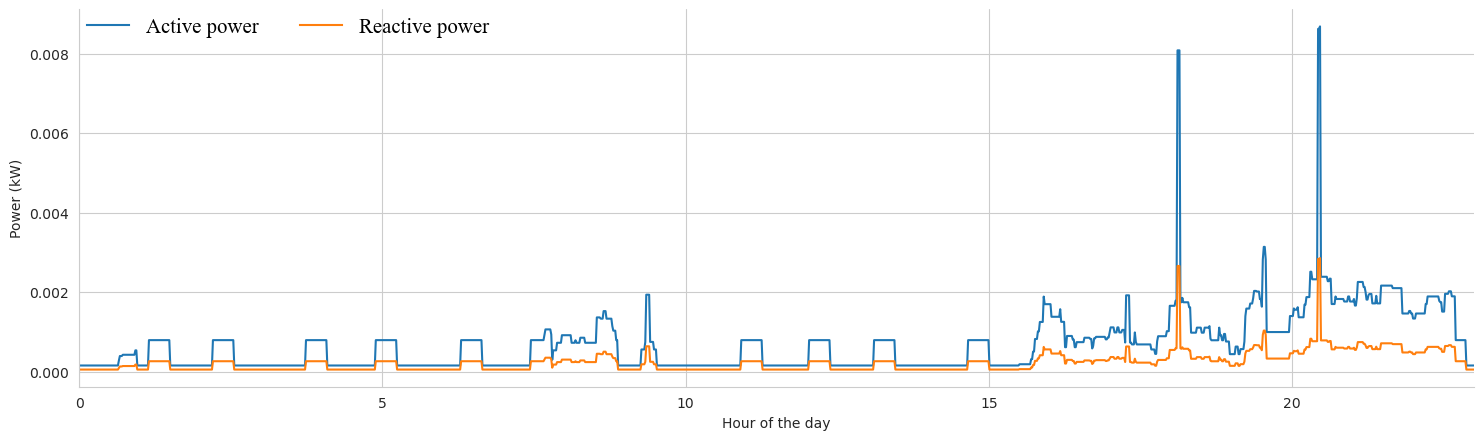

In [15]:
load_number = 54

fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)
plt.plot(np.linspace(0,23,1*1440),p_load[load_number])
plt.plot(np.linspace(0,23,1*1440),q_load[load_number])
plt.xlabel('Hour of the day')
plt.ylabel('Power (kW)')
plt.xlim(0,23)
plt.legend(['Active power', 'Reactive power'], fontsize=15, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.grid(visible=None)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

## Electricity price

In [16]:
#Electricity price data
electricity_price = np.loadtxt(r'../data/electricity price/electricity_price_original.csv', delimiter=",")
price_array_simple = electricity_price

## EVs

In [17]:
# Reading EVs data and preparing it for optimization
evs_df = pd.read_csv(r'../data/evs/ev_data_55.csv' , index_col=False)
evs_df['Bus'] = load_data_df['Bus']
agent_data = {}
for i in range(0,len(evs_df)):
    agent_data[i] = {'start': int(np.floor(evs_df['t_depart(d+1)'][i]/interval)), 'end': int(np.ceil(evs_df['t_arrive'][i]/interval)), 'goal': evs_df['chrg_req'][i]/interval}

agent_data

{0: {'start': 694, 'end': 1286, 'goal': 191.0},
 1: {'start': 550, 'end': 650, 'goal': 129.0},
 2: {'start': 411, 'end': 1069, 'goal': 80.0},
 3: {'start': 438, 'end': 1330, 'goal': 65.0},
 4: {'start': 33, 'end': 961, 'goal': 95.0},
 5: {'start': 111, 'end': 1195, 'goal': 66.0},
 6: {'start': 204, 'end': 1098, 'goal': 159.0},
 7: {'start': 862, 'end': 1262, 'goal': 233.0},
 8: {'start': 190, 'end': 290, 'goal': 233.0},
 9: {'start': 1047, 'end': 1369, 'goal': 233.0},
 10: {'start': 795, 'end': 1271, 'goal': 195.0},
 11: {'start': 391, 'end': 1229, 'goal': 158.0},
 12: {'start': 788, 'end': 1266, 'goal': 233.0},
 13: {'start': 799, 'end': 1078, 'goal': 50.0},
 14: {'start': 418, 'end': 772, 'goal': 106.0},
 15: {'start': 963, 'end': 1063, 'goal': 223.0},
 16: {'start': 363, 'end': 1286, 'goal': 88.0},
 17: {'start': 1113, 'end': 1177, 'goal': 233.0},
 18: {'start': 1096, 'end': 1173, 'goal': 89.0},
 19: {'start': 583, 'end': 1160, 'goal': 70.0},
 20: {'start': 467, 'end': 1359, 'goal':

# Optimization
## Parameters

In [18]:
#Optimization Temporal Values
t_end = 1440     #Total duration of the study(in minutes)
del_T = 60     #Imbalance Settlement Period (in minutes)
del_t = int(1440/interval)      #Temporal resolution of the study (in minutes)
s_data = solar_data1[58]

## Variables Initialization

In [19]:
#Decision Variales for Power Flow
p_ab = (cp.Variable((len(B),len(B))))
q_ab = (cp.Variable((len(B),len(B))))
theta = (cp.Variable((len(B),del_t)))
voltage = (cp.Variable((len(B),del_t)))
p_bus = (cp.Variable((len(B),del_t)))
q_bus = (cp.Variable((len(B),del_t)))
p_gen = (cp.Variable((1,del_t)))
q_gen = (cp.Variable((1,del_t)))

#Variables for Active power decisions
#EV Active Charging power, discharging power and charging decision variables
p_ev_chrg = {i: (cp.Variable((1,del_t), nonneg=True)) for i in evs_df['Bus'].values}

## Constraints

In [20]:
#Lists to store constraints
#Line flow constraints list
line_constraints = []
#bus constraints list
bus_constraints = []
#vehicle constraints list
vehicle_constraints = []
# Agents constraints list

agents_constraints = []
# Power flow constraints
line_constraints.append(p_bus == (G@voltage + B@theta))
line_constraints.append(q_bus == (B@voltage - G@theta))
#Bus 0 is considered as generator bus
bus_constraints.append(p_bus[0] == p_gen[0] + (signal.resample(s_data, int(1440/interval))*1000)/s_base)
bus_constraints.append(q_bus[0] == q_gen[0])
#Initial values for generator bus
bus_constraints.append(voltage[0] == nom_voltage/v_base_sec)
for i in range(1,len(G)):
    if i in evs_df['Bus'].values:
        bus_constraints.append(p_bus[i] == signal.resample(-p_load[i], int(1440/interval)) - p_ev_chrg[i][0])
        bus_constraints.append(q_bus[i] ==  signal.resample(-q_load[i], int(1440/interval)))
    else:
        bus_constraints.append(p_bus[i] == 0)
        bus_constraints.append(q_bus[i] == 0)
#Max allowed powers thorugh lines (both inflow and outflow)
line_constraints.append((p_bus) <= 44.5) #4.5
line_constraints.append((p_bus) >= -44.5) #-4.5
#Voltage limits
bus_constraints.append(cp.abs((1-voltage)*100) <= voltage_tolerance)
#Constraint to model line congestions
congested_line_power = cp.sum([p_bus[a] for a in range(1,206)],axis=0)  #Subdistric 1 is defined between Bus 3 and 207
line_constraints.append(congested_line_power <= 0.55) #0.45
line_constraints.append(congested_line_power >= -0.55) #0.45

for i in range(0,len(agent_data)):
    ind11 = np.linspace(int(agent_data[i]['start']-1), int(agent_data[i]['end']-1), (int(agent_data[i]['end'])-int(agent_data[i]['start'])+1))
    agents_constraints.append((cp.sum(p_ev_chrg[list(p_ev_chrg)[i]][0][:])) >= ((agent_data[i]['goal']*7)*(1000/s_base)))
    agents_constraints.append(p_ev_chrg[list(p_ev_chrg)[i]][0][:] <= 7*(1000/s_base))

    ind = np.linspace(int(agent_data[i]['start']-1), int(agent_data[i]['end']-1), (int(agent_data[i]['end'])-int(agent_data[i]['start'])+1))
    is_empty = ind.size == 0
    if (not is_empty):
        agents_constraints.append(p_ev_chrg[list(p_ev_chrg)[i]][0][ind.astype(int)] == 0)

## Cost function

In [21]:
cost = []
cost.append(price_array_simple @ cp.abs(p_gen[0]))

fair_policy_cost = []
i=6
ind = np.linspace(int(agent_data[i]['start']-1), int(agent_data[i]['end']-1), (int(agent_data[i]['end'])-int(agent_data[i]['start'])+1))
agent1_goal = int(np.maximum(agent_data[i]['goal'] - (np.sum(np.minimum((signal.resample(s_data,int(1440/interval))[np.setdiff1d(np.linspace(0,int(1440/interval)-1,int(1440/interval)),ind).astype(int)]),7)/7)),0))

for i in range(0,len(agent_data)):
    ind = np.linspace(int(agent_data[i]['start']-1), int(agent_data[i]['end']-1), (int(agent_data[i]['end'])-int(agent_data[i]['start'])+1))
    agent_i_goal = int(np.maximum(agent_data[i]['goal'] - (np.sum(np.minimum((signal.resample(s_data,int(1440/interval))[np.setdiff1d(np.linspace(0,int(1440/interval)-1,int(1440/interval)),ind).astype(int)]),7)/7)),0))

    if (agent_i_goal > 0 and i!=6):
        fair_policy_cost.append(cp.abs(cp.sum(price_array_simple @ p_ev_chrg[list(p_ev_chrg)[6]][0])/agent1_goal - cp.sum(price_array_simple @ p_ev_chrg[list(p_ev_chrg)[i]][0])/agent_i_goal))

## Problem Initialization

In [22]:
constraints = line_constraints + bus_constraints + agents_constraints
# Constructing Complete Objective Function
total_cost = cp.sum(cost+fair_policy_cost)
prob = cp.Problem(cp.Minimize(total_cost), constraints)

In [23]:
#List of installed solvers on the PC
cp.installed_solvers()

['CBC',
 'CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'GUROBI',
 'OSQP',
 'SCIPY',
 'SCS']

## Solving the optimziation problem

In [24]:
prob.solve(solver = cp.GUROBI, verbose = 1)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 01 08:08:58 PM: Your problem has 1268640 variables, 585 constraints, and 0 parameters.
(CVXPY) Oct 01 08:08:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 01 08:08:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 01 08:08:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 01 08:08:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 01 08:08:58 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatri

15.698195623929388

In [25]:
tot_evs_power = np.zeros((55,1440))
dd=0
for e in p_ev_chrg:
    tot_evs_power[dd] = p_ev_chrg[e].value[0]
    dd = dd+1

print("Total charging cost on the selected day is:", np.sum(np.maximum((np.sum(tot_evs_power,axis=0)*s_base/1000) - s_data,0) * price_array_simple))

Total charging cost on the selected day is: 916.5225554184348
